## anaconda prompt 열어서 pip install catboost 하고 conda install seaborn 해주면 됩니다

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error
import lightgbm as lgb
import catboost as cat
import gc

In [2]:
# train = pd.read_csv('train_V2_original.csv')
# test = pd.read_csv('test_V2_original.csv')
train = pd.read_pickle('train_V2.pkl')
# test = pd.read_pickle('test_V2.pkl')

In [3]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [4]:
# test.head()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [6]:
def rstr(df, pred=None):
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/obs) *100
    skewness = df.skew()
    kurtosis = df.kurt()
    print('Data shape: ', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', 'corr']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis=1)
    else:
        corr = df.corr()[pred]
        str =pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis=1, sort=False)
        corr_col = 'corr ' + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis',  corr_col]
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

### feature들의 대략적인 통계치, 마지막 열은 target과의 상관계수를 의미 -> 1에 가까울수록 target과의 선형관계가 높다고 볼 수 있음
### but 선형관계를 나타내는 지표이기 때문에 낮다고 해서 아예 관계가 없다고 볼 수는 없다.
#### 데이터 크기 줄인 후 실행하니 일부 지표는 안나옴. 참고

In [7]:
# pd.set_option('display.max_rows', None)
# details = rstr(train, 'winPlacePerc')
# display(details.sort_values(by='corr winPlacePerc', ascending=False))
##시간 오래걸림 주의!!!

# **데이터 크기 줄이기**
# 이 부분은 다른 kernel 참조하여 작성했음
# 최초 실행 이후 주석처리할것!!

In [8]:
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

In [9]:
# reduced_train = reduce_mem_usage(train)
# reduced_test = reduce_mem_usage(test)
# reduced_train.to_pickle('train_V2.pkl')
# reduced_test.to_pickle('test_V2.pkl')
# del train
# del test
# gc.collect()

## EDA

In [10]:
# 몇번의 매치로부터 추출된 데이터들인가?
train.loc[:, 'matchId'].nunique()

47965

In [11]:
# 게임 종류(match type)에 따라 나누기
match_type = train.loc[:, 'matchType'].value_counts().to_frame().reset_index()
match_type.columns = ['matchType', 'Count']
match_type

,matchType,Count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536762
4,duo,313591
5,solo,181943
6,normal-squad-fpp,17174
7,crashfpp,6287
8,normal-duo-fpp,5489
9,flaretpp,2505


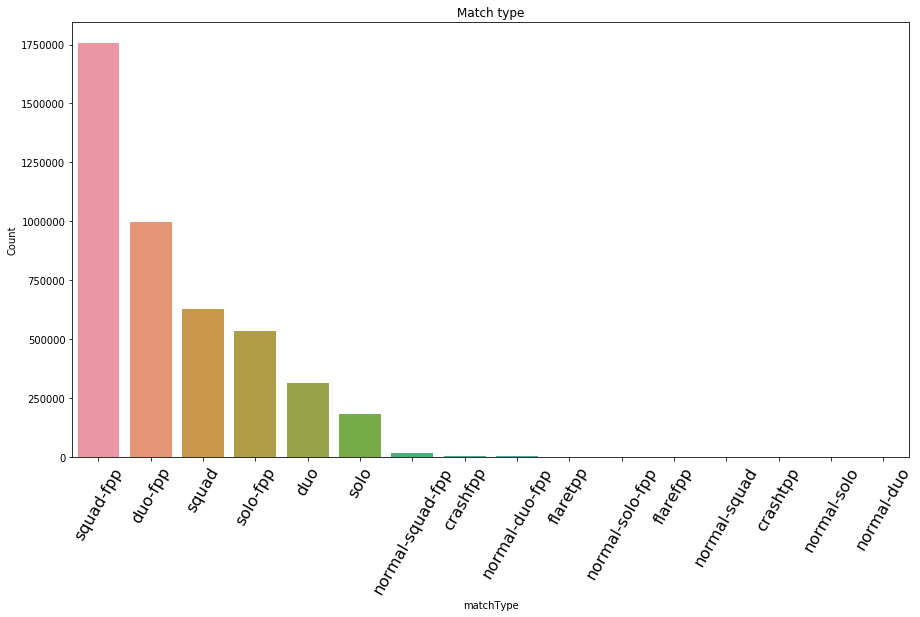

In [12]:
plt.figure(figsize=(15,8))
type_count = match_type.matchType.values
ax = sns.barplot(x='matchType', y='Count', data=match_type)
ax.set_xticklabels(type_count, rotation=60, fontsize=16)
ax.set_title('Match type')
plt.show()

In [13]:
match_type2 = train.loc[:, 'matchType'].value_counts().to_frame()
class_squad = match_type2.loc[["squad-fpp","squad","normal-squad-fpp","normal-squad"],"matchType"].sum()
class_duo = match_type2.loc[["duo-fpp","duo","normal-duo-fpp","normal-duo"],"matchType"].sum()
class_solo = match_type2.loc[["solo-fpp","solo","normal-solo-fpp","normal-solo"],"matchType"].sum()
classify = pd.DataFrame([class_squad, class_duo, class_solo], index=['squad', 'duo', 'solo'], columns = ['Count'])
classify

psquad = classify.loc['squad', 'Count']
pduo = classify.loc['duo', 'Count']
psolo = classify.loc['solo', 'Count']
total = psquad + pduo + psolo

print('전체 중에서 스쿼드의 비율은 %.2f, 듀오의 비율은 %.2f, 솔로의 비율은 %.2f입니다.' 
      % (psquad / total, pduo / total, psolo / total))
## 일단 이벤트 매치는 생각 안함

전체 중에서 스쿼드의 비율은 0.54, 듀오의 비율은 0.30, 솔로의 비율은 0.16입니다.


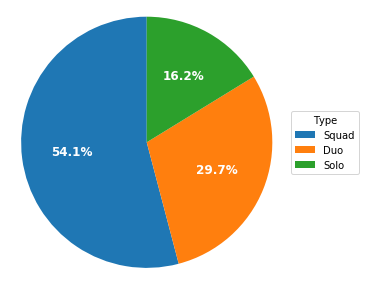

In [14]:
fig1, ax1 = plt.subplots(figsize=(5, 5))
labels = ['Squad', 'Duo', 'Solo']

wedges, texts, autotexts = ax1.pie(classify['Count'], textprops=dict(color='w'), 
                                   autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
ax1.legend(wedges, labels,
          title='Type',
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight='bold')
plt.show()

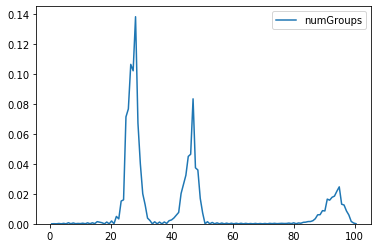

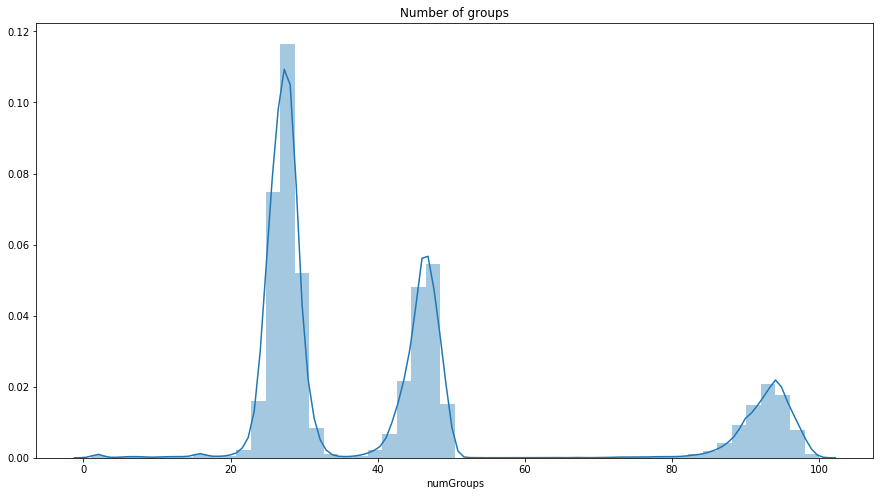

In [15]:
# 한 매치에 몇팀?
sns.kdeplot(train['numGroups'], bw=0.15)

plt.figure(figsize=(15,8))
ax = sns.distplot(train['numGroups'])
ax.set_title('Number of groups')
plt.show()

## kills & damagedealt

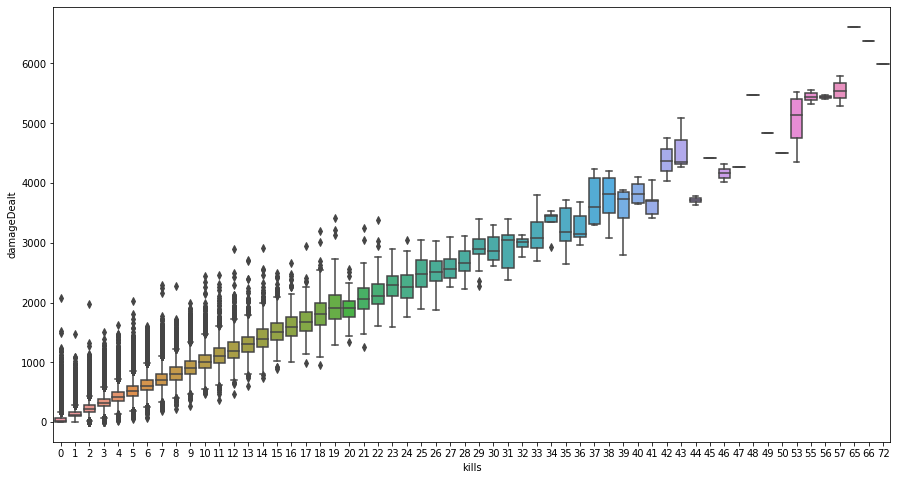

In [16]:
plt.figure(figsize=(15,8))
ax1 = sns.boxplot(x='kills', y='damageDealt', data=train)
ax.set_title('Kills & Damage Dealt')
plt.show()
## 단위 통일 후  pca 고려 가능

In [17]:
# 핵쟁이를 찾아보자.
train[(train['kills'] > 43) & (train['headshotKills']/train['kills'] > 0.5)][
    ['assists', 'damageDealt', 'headshotKills', 'kills', 'longestKill']]

,assists,damageDealt,headshotKills,kills,longestKill
1454065,2,4496.0,42,50,324.250
2020831,2,4888.0,46,53,690.500
2601666,5,4348.0,31,53,135.625
2914453,2,4840.0,27,49,188.750
3431247,7,5992.0,64,72,78.250
3673965,2,5328.0,41,55,310.250


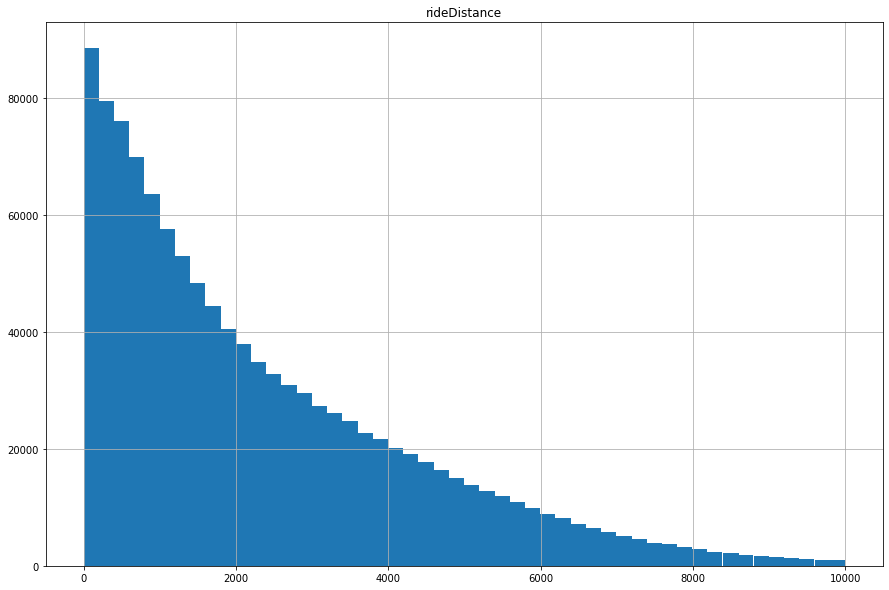

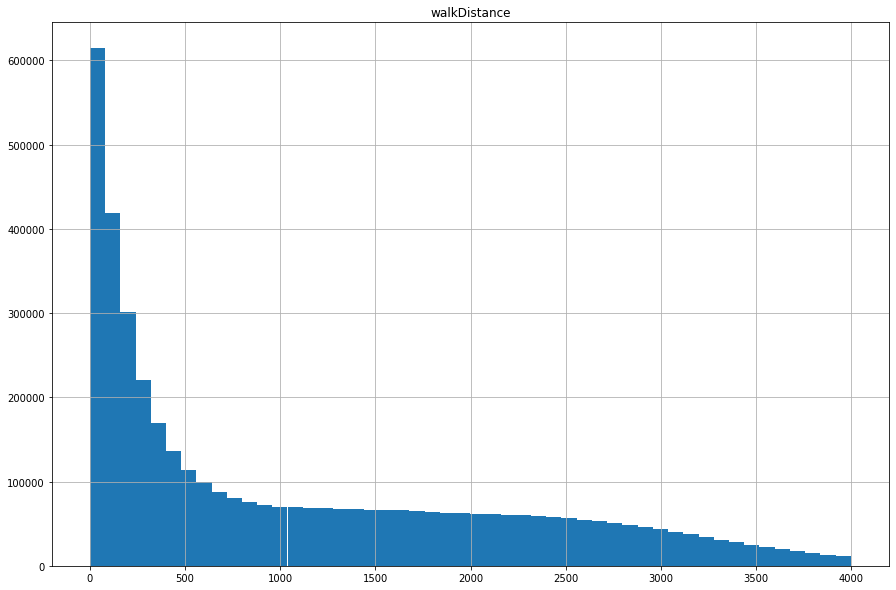

In [18]:
ride = train.query('rideDistance >0 & rideDistance <10000')
walk = train.query('walkDistance >0 & walkDistance <4000')
ride.hist('rideDistance', bins=50, figsize = (15,10))
walk.hist('walkDistance', bins=50, figsize = (15,10))
plt.show()

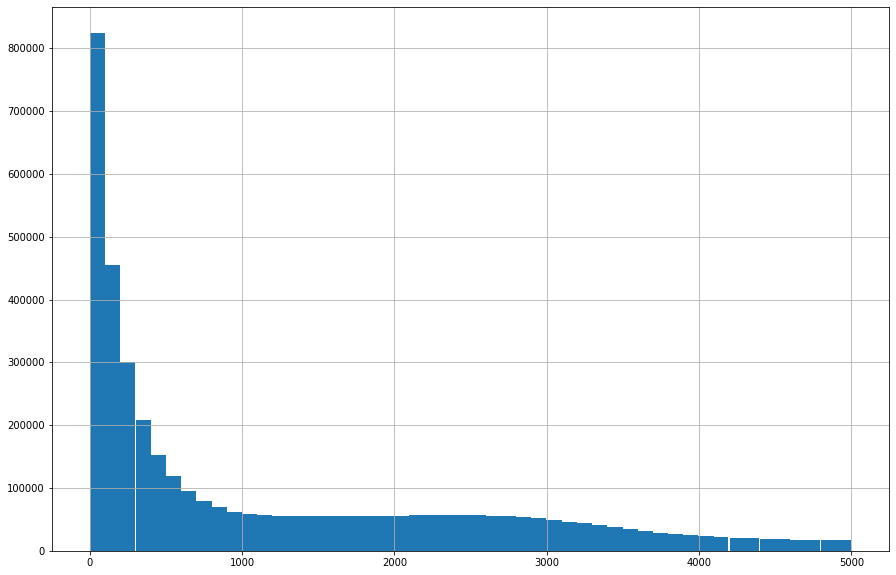

In [19]:
# 총 Distance는 어떤식?
travel_dist = train["walkDistance"] + train["rideDistance"] + train["swimDistance"]
travel_dist = travel_dist[travel_dist<5000]
travel_dist.hist(bins=50, figsize = (15,10))
plt.show()

***실제 분포는 walkDistance와 totalDisance가 유사 -> distance 관련 데이터는 합치기!!***

In [20]:
train['weaponsAcquired'].describe()

count    4.446966e+06
mean     3.660488e+00
std      2.456544e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      2.360000e+02
Name: weaponsAcquired, dtype: float64

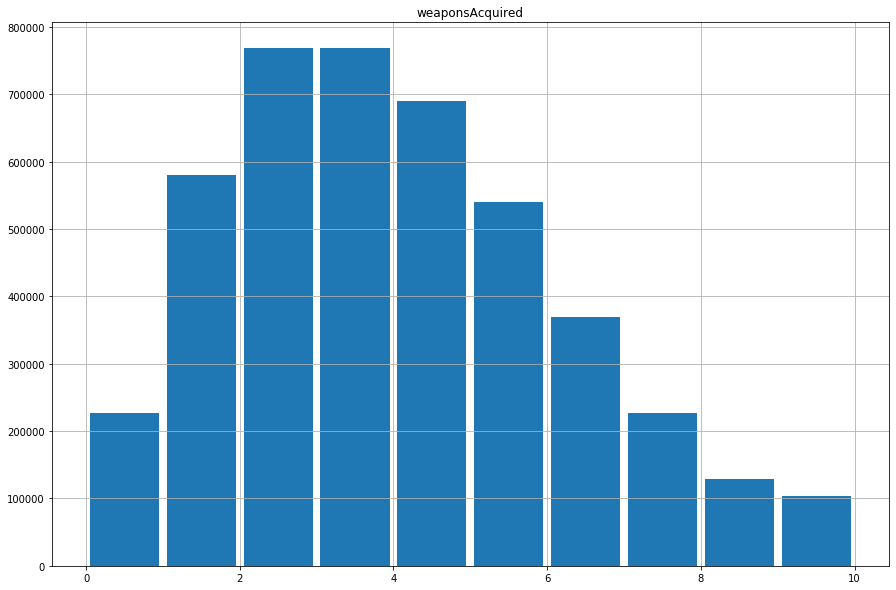

In [21]:
train.hist('weaponsAcquired', figsize=(15, 10), range=(0, 10), rwidth=0.9)
plt.show()

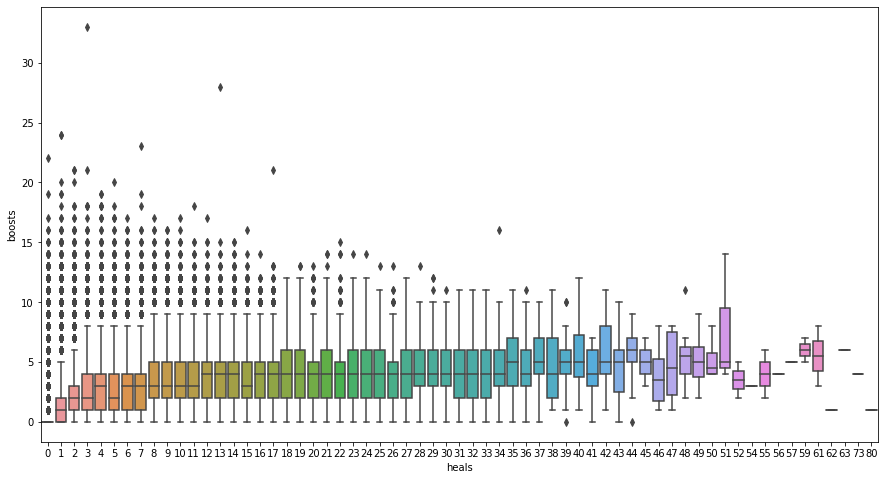

In [22]:
plt.figure(figsize=(15,8))
ax1 = sns.boxplot(x='heals', y='boosts', data=train)
ax.set_title('boosts & heals')
plt.show()
# 두 변수를 합칠 필요는 없어 보임

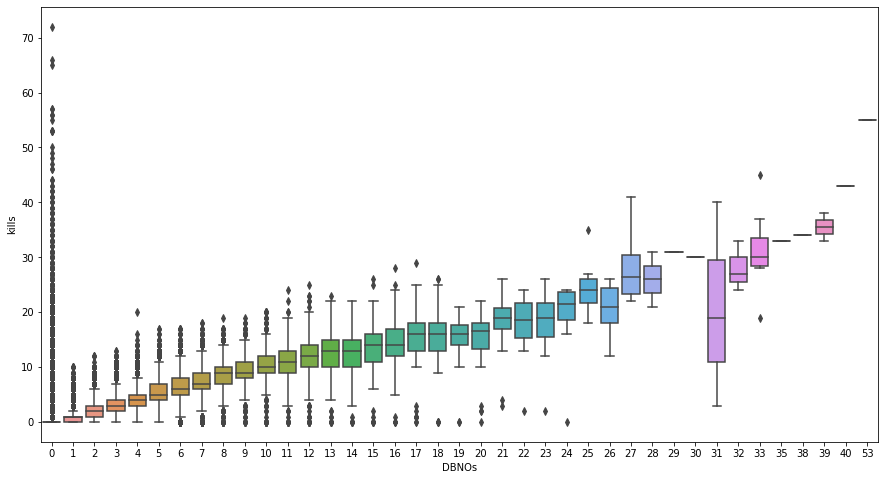

In [23]:
plt.figure(figsize=(15,8))
ax1 = sns.boxplot(x='DBNOs', y='kills', data=train)
ax.set_title('DBNOs & kills')
plt.show()
## 둘은 확실히 연관성이 있어보임 -> 0에 있는 이상치들은 솔로플레이에 해당되는 경우로 예상(솔로에는 기절이 없음)

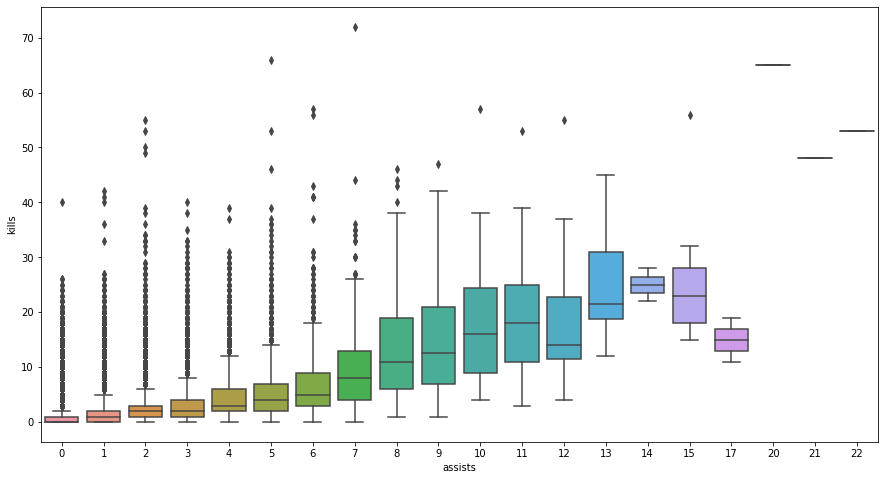

In [24]:
plt.figure(figsize=(15,8))
ax1 = sns.boxplot(x='assists', y='kills', data=train)
ax.set_title('assists & kills')
plt.show()
# 이쪽도 연관성은 있어 보임

## 1차 Feature Engineering

In [25]:
train["group_size"] = train.groupby(["groupId"])['Id'].transform('count') # match별 그룹수 카운트 
train["killPlace"] = train["killPlace"]/train["group_size"] # killPlace를 매치 인원 수로 나눠줌으로써 0~1 사이로 정규화 (솔로에서는 한명한명이 별개의 그룹)
train["totalDistance"] = train['walkDistance'] + train['rideDistance'] + train['swimDistance'] # 거리 관련 데이터는 전부 합산해서 계산
train["killPlace"] = -1*train["killPlace"] # target 변수와의 상관계수가 음수가 나오므로 -1 곱해줌
train["headshotRatio"] = train["headshotKills"]/(train["kills"]+1) # 전체 킬 중 헤드샷이 차지하는 비중
train["killStreakRatio"] = train["killStreaks"]/(train["kills"]+1)  
train["killSum"] = train["kills"]+train["DBNOs"]+train["assists"]+train["roadKills"] # 킬 관련 데이터는 합친다.

In [26]:
train = train.drop(['walkDistance', 'rideDistance', 'swimDistance', 'headshotKills', 'killStreaks',
                    'kills', 'DBNOs', 'assists', 'roadKills'], axis=1)
## 합치거나 변환한 변수들은 drop

### solo match와 duo, squad의 경우 처리를 다르게 해야 할 필요가 있음, 하지만 변수들을 그룹별 평균이나 합으로 변환한다면 같은 효과를 냄
### 이산형 변수 -> 합, 연속형 변수 -> 평균

In [27]:
## 평균 변환 함수
def getMean(df, col):
    df[col+'mean'] = df.groupby(['groupId'])[col].transform(np.mean)
    df = df.drop(col, axis=1)
## 합 변환 함수
def getSum(df, col):
    df[col+'sum'] = df.groupby(["groupId"])[col].transform(np.sum)
    df = df.drop(col, axis=1)

In [28]:
mean_cols = ['damageDealt', 'killPlace', 'longestKill', 'totalDistance', 'headshotRatio', 'killStreakRatio']
sum_cols = ['boosts', 'heals', 'revives', 'teamKills', 'vehicleDestroys','weaponsAcquired']

In [29]:
for col in mean_cols:
    getMean(train, col)
for col in sum_cols:
    getSum(train, col)

### rankPoints, winPoints, killPoints와 같은 레이팅 관련 데이터는 deprecated 되서 누락된 값들이 많음.
### 활용하되, 스케일 조정 필요 -> 제곱근 or 로그 씌우기!!

In [30]:
train['rankPoints'] = np.cbrt(train['rankPoints']+1)
train['winPoints'] = np.cbrt(train['winPoints'])
train['killPoints'] = np.cbrt(train['killPoints'])


In [31]:
print("min : %.3f,   max : %.3f" % (train.rankPoints.min(),train.rankPoints.max()))
print("min : %.3f,   max : %.3f" % (train.winPoints.min(),train.winPoints.max()))
print("min : %.3f,   max : %.3f" % (train.killPoints.min(),train.killPoints.max()))

min : 0.000,   max : 18.081
min : 0.000,   max : 12.626
min : 0.000,   max : 12.947


In [32]:
train.columns

Index(['Id', 'groupId', 'matchId', 'boosts', 'damageDealt', 'heals',
       'killPlace', 'killPoints', 'longestKill', 'matchDuration', 'matchType',
       'maxPlace', 'numGroups', 'rankPoints', 'revives', 'teamKills',
       'vehicleDestroys', 'weaponsAcquired', 'winPoints', 'winPlacePerc',
       'group_size', 'totalDistance', 'headshotRatio', 'killStreakRatio',
       'killSum', 'damageDealtmean', 'killPlacemean', 'longestKillmean',
       'totalDistancemean', 'headshotRatiomean', 'killStreakRatiomean',
       'boostssum', 'healssum', 'revivessum', 'teamKillssum',
       'vehicleDestroyssum', 'weaponsAcquiredsum'],
      dtype='object')

## 2차 Feature Engineering

## 연관성이 없어보이는 feature는 그냥 삭제한다

In [33]:
train = train.drop(['teamKillssum', 'maxPlace'], axis=1)

In [34]:
train.columns

Index(['Id', 'groupId', 'matchId', 'boosts', 'damageDealt', 'heals',
       'killPlace', 'killPoints', 'longestKill', 'matchDuration', 'matchType',
       'numGroups', 'rankPoints', 'revives', 'teamKills', 'vehicleDestroys',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'group_size',
       'totalDistance', 'headshotRatio', 'killStreakRatio', 'killSum',
       'damageDealtmean', 'killPlacemean', 'longestKillmean',
       'totalDistancemean', 'headshotRatiomean', 'killStreakRatiomean',
       'boostssum', 'healssum', 'revivessum', 'vehicleDestroyssum',
       'weaponsAcquiredsum'],
      dtype='object')

## killSum과 직접적인 연관성이 있어보이는 feature -> damageDealtmean
## dmdealt&kill(가한 데미지 대비 킬 수) : killSum / (damageDealtmean+1) *분모가 0이 되는 것을 방지하기 위해 1 더함*
## 기존의 killSum과 방향성이 같을 수 있으므로 killSum은 삭제

In [35]:
train['dmdealt&kill'] = train['killSum'] / (train['damageDealtmean']+1)

In [36]:
train = train.drop(['killSum'], axis=1)

## 전처리한 변수들 시각화

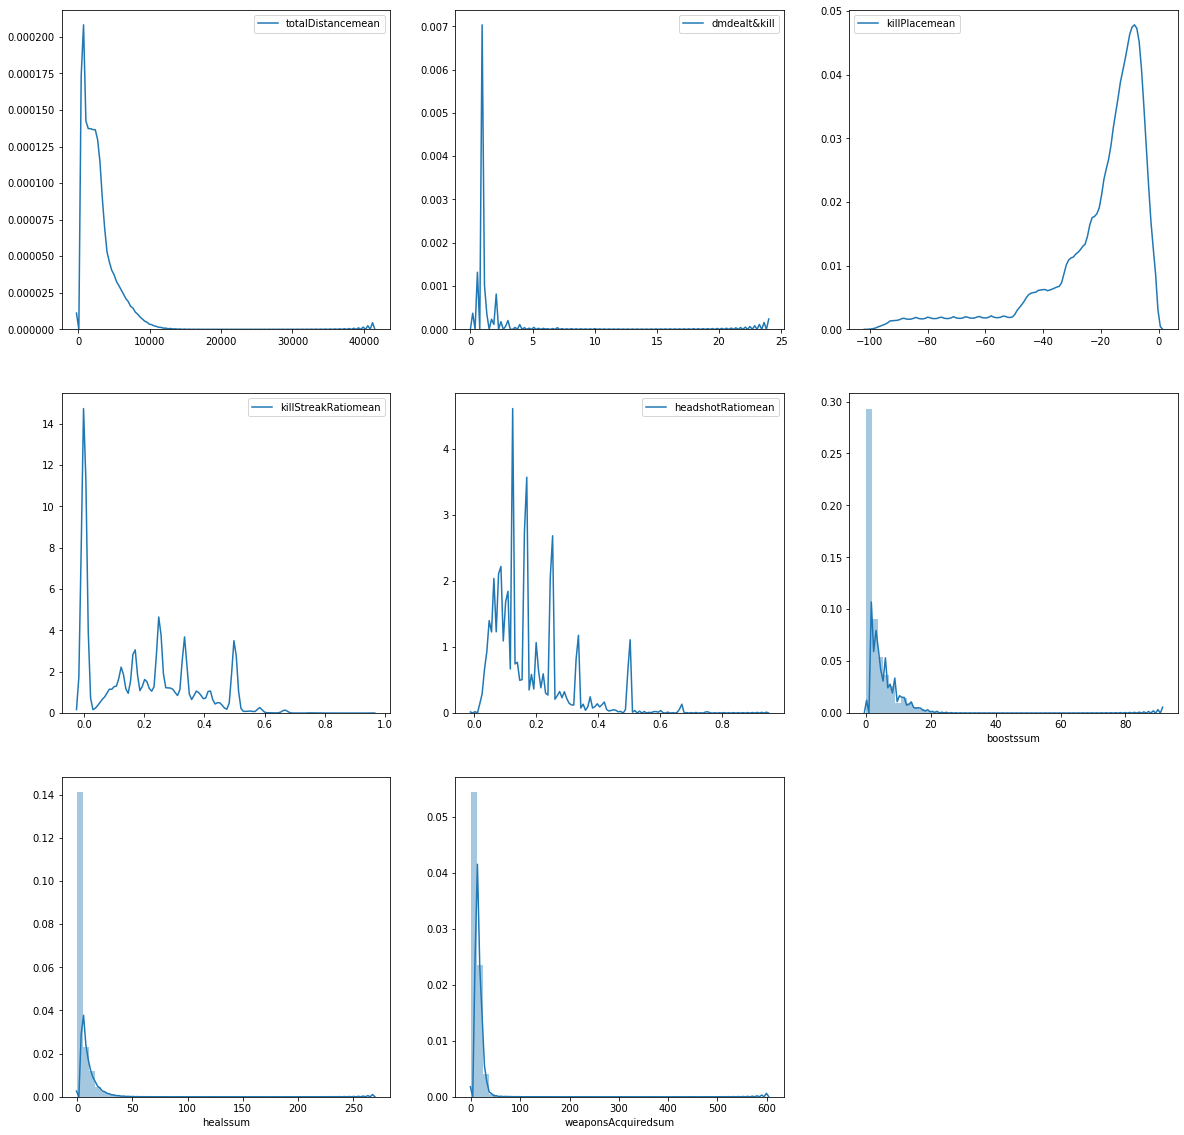

In [37]:
plt.figure(figsize=(20,20))
plt.subplot(331)
sns.kdeplot(train['totalDistancemean'])
plt.subplot(332)
sns.kdeplot(train['dmdealt&kill'])
plt.subplot(333)
sns.kdeplot(train['killPlacemean'])
plt.subplot(334)
sns.kdeplot(train['killStreakRatiomean'])
plt.subplot(335)
sns.kdeplot(train['headshotRatiomean'])
plt.subplot(336)
sns.distplot(train['boostssum'])
plt.subplot(337)
sns.distplot(train['healssum'])
plt.subplot(338)
sns.distplot(train['weaponsAcquiredsum'])
plt.show()

### 게임 특성상 시작하자마자 죽는 경우가 많아 전처리를 해도 분포가 한쪽에 쏠려있는 경우 대다수
### 로그나 제곱근을 씌워줄 필요가 있음
### 단위가 크거나 왜도가 심한 경우 -> 로그, 그 외 -> 제곱근

In [38]:
train['killPlacemean'] = -1*train['killPlacemean'] #음수값이므로 부호 반전 시켜준다

In [39]:
def logtransform(df, col):
    df[col] = np.log1p(df[col])
def sqrttransform(df, col):
    df[col] = np.log1p(df[col])

In [40]:
loglist = ['totalDistancemean', 'boostssum', 'healssum', 'weaponsAcquiredsum']
sqrtlist = ['killPlacemean', 'dmdealt&kill']

In [41]:
for logcol in loglist:
    logtransform(train, logcol)
for sqrtcol in sqrtlist:
    sqrttransform(train, sqrtcol)

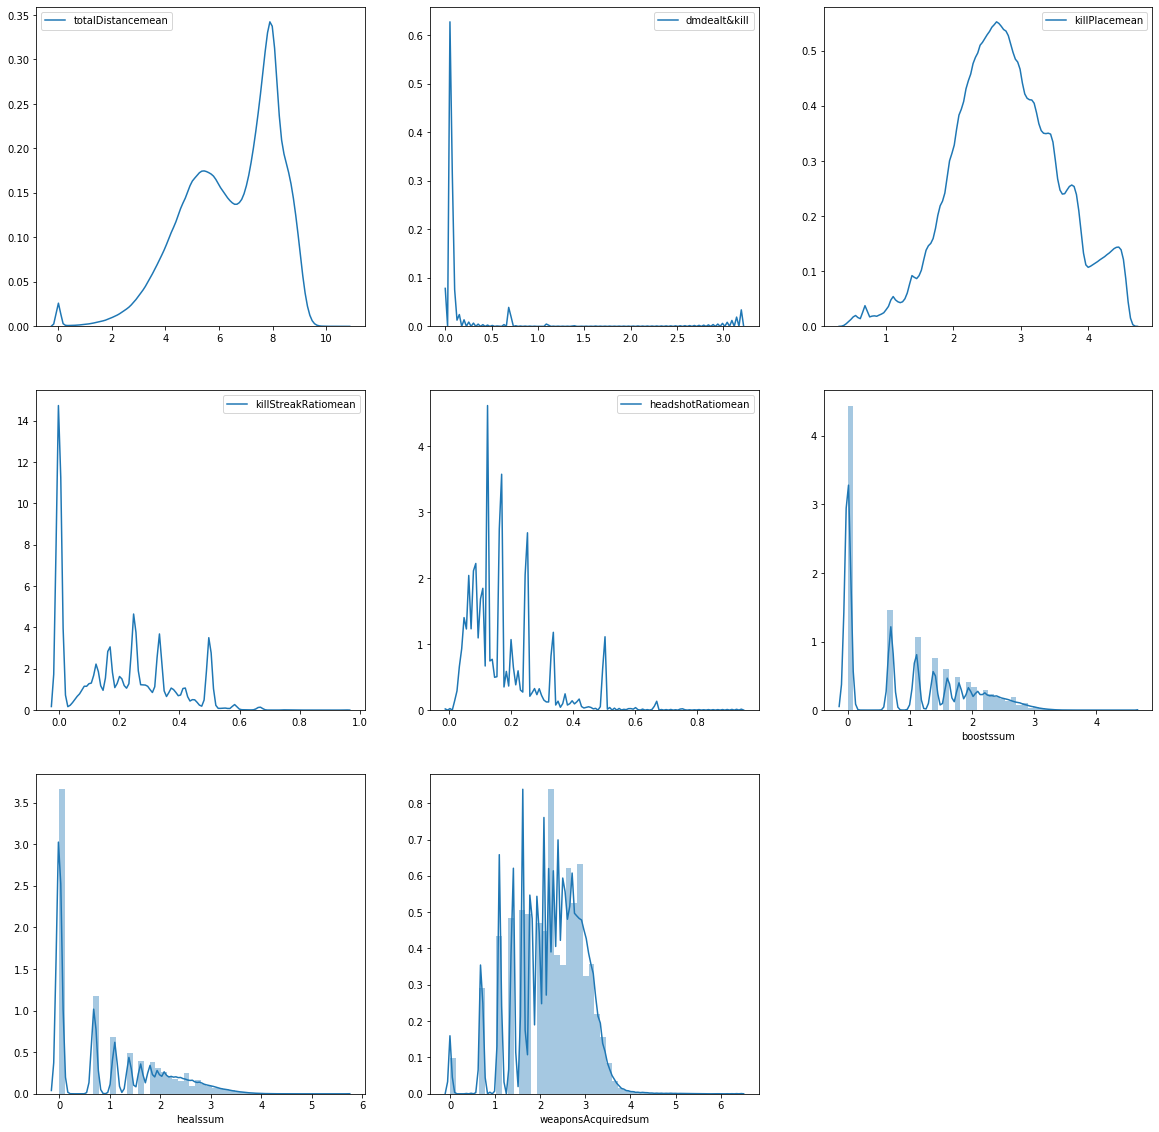

In [42]:
plt.figure(figsize=(20,20))
plt.subplot(331)
sns.kdeplot(train['totalDistancemean'])
plt.subplot(332)
sns.kdeplot(train['dmdealt&kill'])
plt.subplot(333)
sns.kdeplot(train['killPlacemean'])
plt.subplot(334)
sns.kdeplot(train['killStreakRatiomean'])
plt.subplot(335)
sns.kdeplot(train['headshotRatiomean'])
plt.subplot(336)
sns.distplot(train['boostssum'])
plt.subplot(337)
sns.distplot(train['healssum'])
plt.subplot(338)
sns.distplot(train['weaponsAcquiredsum'])
plt.show()

## 일부는 여전히 쏠려있기는 하지만 그래도 어느정도는 개선된 것을 확인할 수 있음